In [ ]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [3]:
# Load the dataset
wine_df = pd.read_csv("/Users/gagan/CSV_Data_Sets/WineQT.csv")

In [4]:
# Display the first few rows
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [5]:
# Drop the 'Id' column if it exists
if 'Id' in wine_df.columns:
    wine_df.drop('Id', axis=1, inplace=True)

In [6]:
# Check for null values
print(wine_df.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [7]:
# Map wine quality to categories
wine_df['quality_grouped'] = wine_df['quality'].apply(
    lambda x: 'Low' if x <= 4 else ('Medium' if x <= 6 else 'High')
)

In [8]:
# Encode the target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
wine_df['quality_grouped'] = le.fit_transform(wine_df['quality_grouped'])


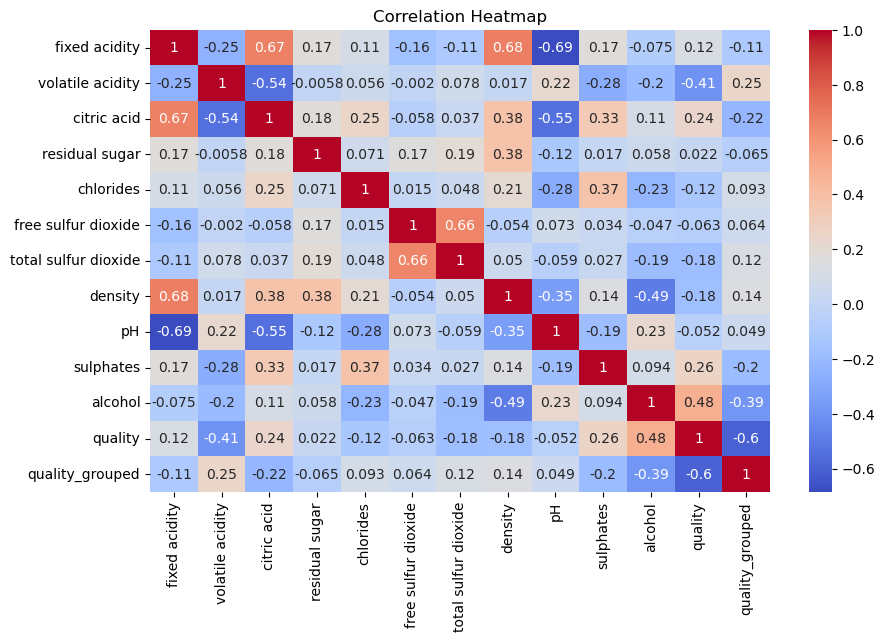

In [9]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(wine_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [10]:
# Select top 4 features based on correlation with quality
top_features = ['alcohol', 'volatile acidity', 'sulphates', 'citric acid']


In [11]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(wine_df[top_features])

In [12]:
# Create linkage matrix for dendrogram
linked = linkage(X_scaled, method='ward')

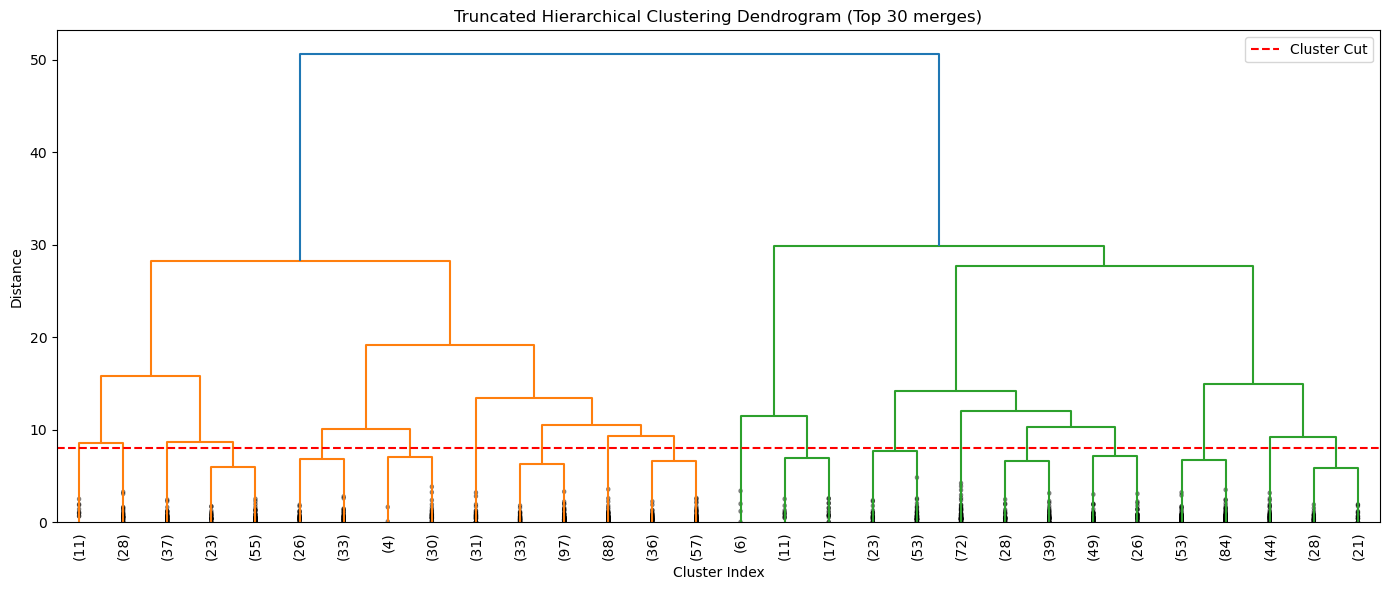

In [22]:
# Plot truncated dendrogram for readability
plt.figure(figsize=(14, 6))

dendrogram(linked,
           truncate_mode='lastp',     
           p=30,                       
           leaf_rotation=90.,
           leaf_font_size=10.,
           show_contracted=True)

plt.title('Truncated Hierarchical Clustering Dendrogram (Top 30 merges)')
plt.axhline(y=8, color='red', linestyle='--', label='Cluster Cut')
plt.legend()
plt.xlabel('Cluster Index')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()


In [14]:
# From dendrogram, let's assume 3 clusters
model = AgglomerativeClustering(n_clusters=3)
wine_df['cluster'] = model.fit_predict(X_scaled)

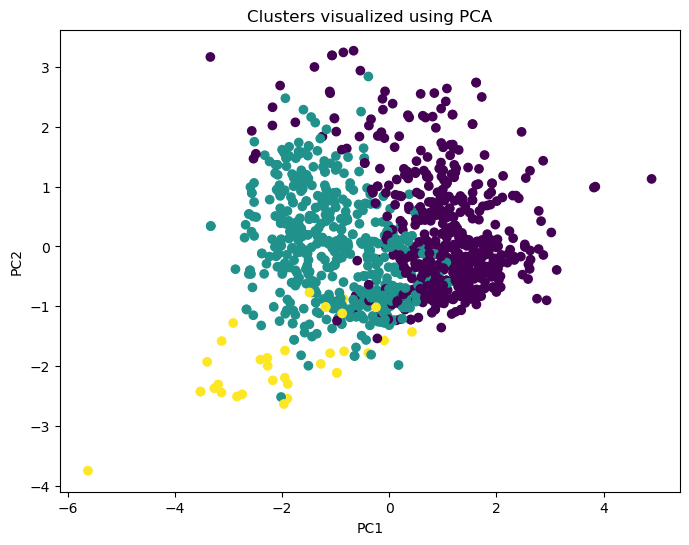

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=wine_df['cluster'])
plt.title("Clusters visualized using PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

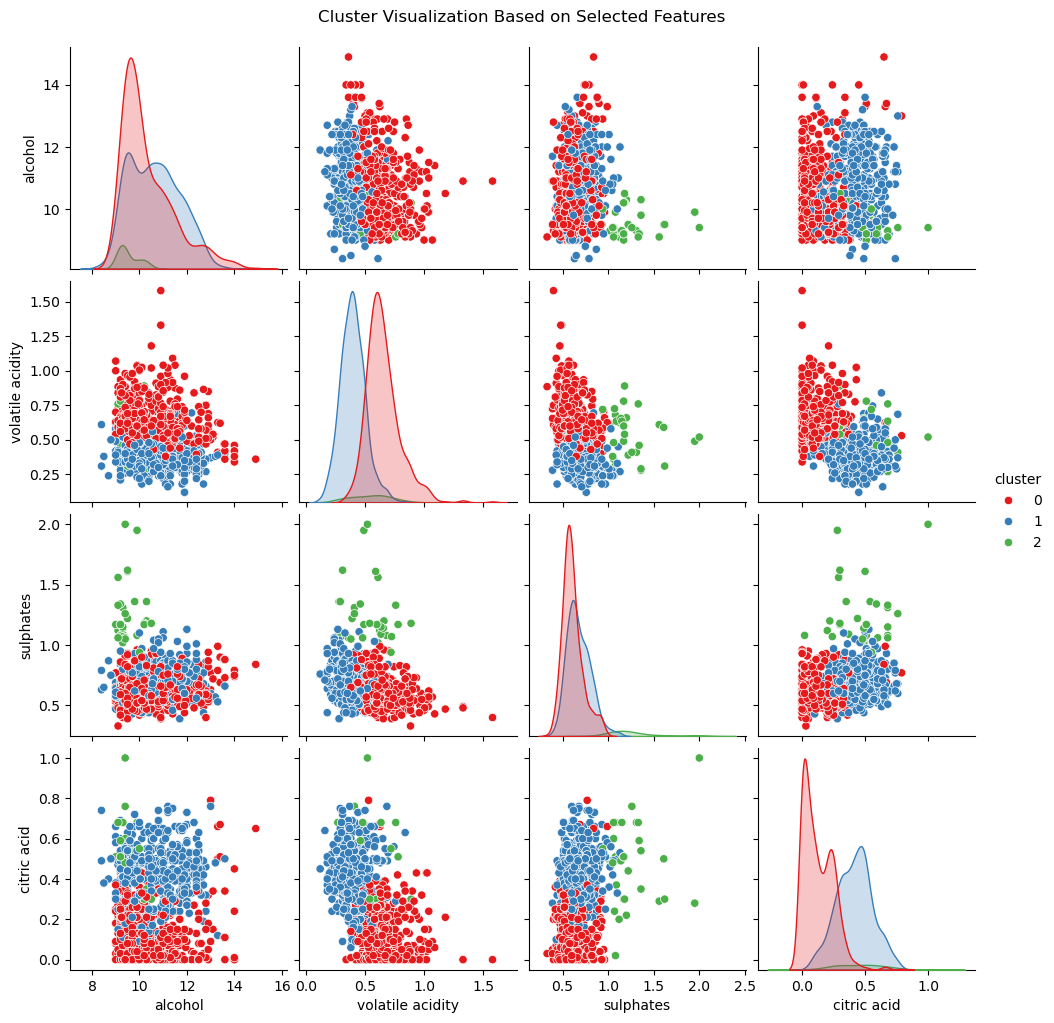

In [15]:
# Visualize clusters with pairplot
sns.pairplot(wine_df[top_features + ['cluster']], hue='cluster', palette='Set1')
plt.suptitle("Cluster Visualization Based on Selected Features", y=1.02)
plt.show()


In [24]:
# Analyze average values of each feature per cluster
cluster_summary = wine_df.groupby('cluster')[top_features].mean()
print("\nCluster Feature Averages:\n")
print(cluster_summary)



Cluster Feature Averages:

           alcohol  volatile acidity  sulphates  citric acid
cluster                                                     
0        10.332965          0.650577   0.605993     0.127674
1        10.624455          0.395548   0.676173     0.415212
2         9.544118          0.542500   1.271176     0.459706


In [ ]:
cluster_stats = wine_df.groupby('cluster')[top_features].agg(['mean', 'std'])
print(cluster_stats) #Standard Deviation 

           alcohol           volatile acidity           sulphates            \
              mean       std             mean       std      mean       std   
cluster                                                                       
0        10.332965  1.101467         0.650577  0.144031  0.605993  0.113049   
1        10.624455  1.044505         0.395548  0.105753  0.676173  0.129275   
2         9.544118  0.430779         0.542500  0.163393  1.271176  0.270933   

        citric acid            
               mean       std  
cluster                        
0          0.127674  0.119632  
1          0.415212  0.141208  
2          0.459706  0.198318  


In [ ]:
print(wine_df['cluster'].value_counts()) #cluster size 

cluster
0    589
1    520
2     34
Name: count, dtype: int64


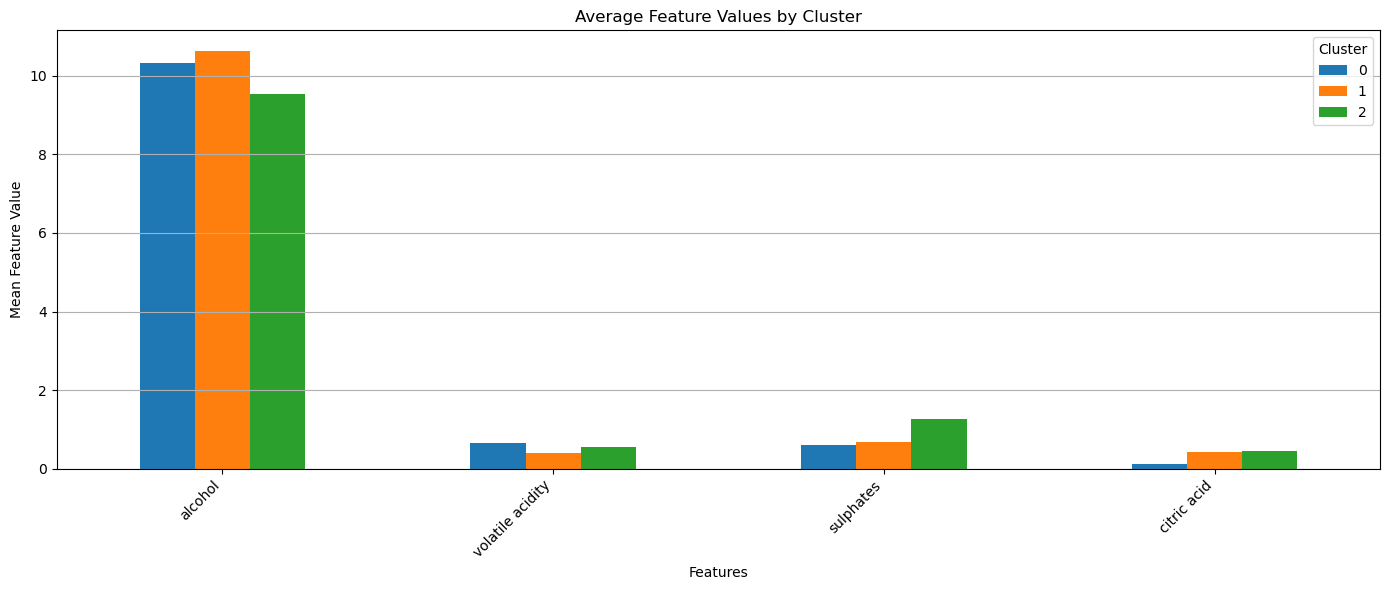

In [17]:
# Better format for comparison: features on x-axis
cluster_summary.T.plot(kind='bar', figsize=(14, 6))

plt.title("Average Feature Values by Cluster")
plt.ylabel("Mean Feature Value")
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [27]:
# Evaluate clusters by comparing with quality labels
contingency_table = pd.crosstab(wine_df['cluster'], wine_df['quality_grouped'],normalize='index')
print("\nContingency Table (Cluster vs Quality Grouped):\n")
print(contingency_table)


Contingency Table (Cluster vs Quality Grouped):

quality_grouped         0         1         2
cluster                                      
0                0.057725  0.047538  0.894737
1                0.236538  0.015385  0.748077
2                0.058824  0.088235  0.852941


In [28]:
from scipy.stats import chi2_contingency

chi2, p, _, _ = chi2_contingency(contingency_table)
print("Chi-square p-value:", p)

Chi-square p-value: 0.9929933462317526


Chi-square p-value = 0.99299 is a very good p-value for unsupervise learning


In [ ]:
# Final thoughts
print("\nConclusion:")
print("- Hierarchical Clustering was performed on the top 4 correlated features.")
print("- A dendrogram was used to determine the number of clusters.")
print("- The resulting clusters show some alignment with wine quality groups, suggesting clustering has some predictive structure.")



Conclusion:
- Hierarchical Clustering was performed on the top 4 correlated features.
- A dendrogram was used to determine the number of clusters.
- The resulting clusters show some alignment with wine quality groups, suggesting clustering has some predictive structure.
